In [1]:
# ! rm -r runs

import gym
import gym_point
import numpy as np
from collections import deque
import torch
import torch.optim as optim

from util import PGN, RewardNet, GRL, float32_preprocessor

from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
GAMMA = 0.95
LEARNING_RATE = 0.0001
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
env = gym.make('PointContinuousEnv-v0')
env.set_curve('CRev') # Curve: 'S', 'C'
env.set_reset_condition('origin') # reset state: 'origin', 'random'

agent_net = PGN(env.observation_space.shape[0], env.action_space.n)
reward_net = RewardNet(env.observation_space.shape[0])

optimizer_agent = optim.Adam(agent_net.parameters(), lr=LEARNING_RATE)
optimizer_reward = optim.Adam(reward_net.parameters(), lr=1e-4, weight_decay=1e-3)

/home/sagrawal/src/gym/gym/logger.py:30: UserWarning: WARN: The dimensions are bigger than 2, only the first 2 dimensions are visualized
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
agent_net.to(device)
reward_net.to(device)

# checkpoint = torch.load('pointspace_policy_net_origin.mod')
# agent_net.load_state_dict(checkpoint)
# agent_net.to(device)

# checkpoint = torch.load('pointspace_reward_net_origin.mod')
# reward_net.load_state_dict(checkpoint)
# reward_net.to(device)

RewardNet(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

Total number of demonstrations:  100
Total number of step demonstrations:  10000


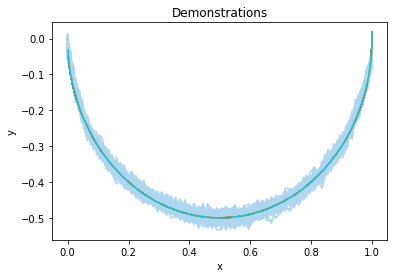

In [5]:
grl = GRL(env, noise=0.01)
demonstrations, XStore_steps, AStore_steps = grl.get_demonstrations(Ndemo=100,Kp=-100, Kd=-3)
# grl.test_demonstrations(demonstrations, Nsamp=5, render=False)
# demonstrations['states'][0][:10], demonstrations['actions'][0][:10]

In [ ]:
total_rewards = []
step_idx = 0
done_episodes = 0
DEMO_BATCH = 256
BSIZE = 256 # batch size

batch_episodes = 0
batch_states, batch_actions, batch_qvals = deque([], BSIZE), deque([], BSIZE), deque([], BSIZE)
net_rewards = deque([], 100)
env_rewards = deque([], 100)
loss_rwd = 0.

while done_episodes < 500000:
    states, actions, rewards, done = agent_net.generate_session(env, BSIZE)
    
    # Store samples in batch
    batch_states.extend(states)
    batch_actions.extend(actions)
    batch_qvals.extend(grl.calc_qvals(rewards))
    env_reward = np.sum(rewards)
    env_rewards.extend([env_reward])
    
    if len(batch_actions) < BSIZE:
        continue
    
    batch_episodes += 1
        
    # Get reward from reward_net
#     x = torch.cat((float32_preprocessor(states), float32_preprocessor(actions).view(-1,1)), dim=1).to(device)
    x = float32_preprocessor(states).to(device)
    net_reward = reward_net(x)
    net_rewards.extend([np.sum(net_reward.cpu().detach().numpy())])
         
    done_episodes += 1

    mean_env_rewards = float(np.mean(env_rewards))
    mean_net_rewards = float(np.mean(net_rewards))

    writer.add_scalar('Episodic Reward', env_reward, done_episodes)
    writer.add_scalar('mean_env_reward', mean_env_rewards, done_episodes)
    writer.add_scalar('mean_net_reward', mean_net_rewards, done_episodes)
    writer.add_scalar('loss_reward_net', loss_rwd, done_episodes)        

    print(f'{done_episodes}: reward: {env_reward:6.2f}, mean_env_reward: {mean_env_rewards:6.2f}, mean_net_reward: {mean_net_rewards:6.2f}, reward function loss: {loss_rwd:6.4f}')

    ## Tensorboard logging 
    if done_episodes%100==0 or mean_env_rewards>=100:
        fig = reward_net.visualize_net(agent_net, Npoints=20)
        writer.add_figure('Reward Net', fig, global_step=done_episodes/100)
        
        test_reward, test_fig = agent_net.test_agent(env,device)
        writer.add_scalar('test_reward', test_reward, done_episodes)
        writer.add_figure('Agent traj', test_fig, global_step=done_episodes/100)
        torch.save(agent_net.state_dict(), 'pointspace_policy_net_origin.mod')
        torch.save(reward_net.state_dict(), 'pointspace_reward_net_origin.mod')

    if mean_env_rewards >= 100:
        print(f'Solved in {step_idx} steps and {done_episodes} episodes!')
        torch.save(agent_net.state_dict(), 'pointspace_policy_net_origin.mod')
        torch.save(reward_net.state_dict(), 'pointspace_reward_net_origin.mod')
#         break

    states_v = torch.FloatTensor(batch_states)
    batch_actions_t = torch.LongTensor(batch_actions)
    batch_qvals_v = torch.FloatTensor(batch_qvals)
  
    Total_steps_demo = len(AStore_steps)

    # reward function learning
    for rf_i in range(1):
        # ToDo: Sample from initial steps
        selected = np.random.choice(Total_steps_demo, DEMO_BATCH)
        demo_states = np.take(XStore_steps, selected, axis=0)
        demo_actions = np.take(AStore_steps, selected, axis=0)
        
        demo_batch_states = torch.FloatTensor(demo_states)
        demo_batch_actions = torch.FloatTensor(demo_actions)
        
#         D_demo = torch.cat([demo_batch_states, demo_batch_actions.view(-1, 1)], dim=-1).to(device)
#         D_samp = torch.cat([states_v, batch_actions_t.float().view(-1, 1)], dim=-1).to(device)
        
        D_demo = demo_batch_states.to(device)
        D_samp = states_v.to(device)
        
        D_samp = torch.cat([D_demo, D_samp])
                
        # dummy importance weights - fix later
        z = torch.ones((D_samp.shape[0], 1)).to(device)

        # objective
        D_demo_out = reward_net(D_demo)
        D_samp_out_net = reward_net(D_samp)
        D_samp_out = z * torch.exp(D_samp_out_net)
        
        loss_rwd = -torch.mean(D_demo_out) + torch.log(torch.mean(D_samp_out))
        optimizer_reward.zero_grad()
        loss_rwd.backward()
        optimizer_reward.step()
    
    # agent
    optimizer_agent.zero_grad()
    logits_v = agent_net(states_v.to(device))
    log_prob_v = torch.log_softmax(logits_v.cpu(), dim=1) # p(a|s)
    
    # batch_qvals_v = E(s)
    # REINFORCE
    log_prob_actions_v = batch_qvals_v * log_prob_v[range(len(batch_states)), batch_actions_t] #q(s,a)=p(a|s)E(s)
    loss_v = -log_prob_actions_v.mean()
    writer.add_scalar('loss_agent_net', loss_v, done_episodes) 
    
    loss_v.backward()
    optimizer_agent.step()

    batch_episodes = 0

env.close()
writer.close()

1: reward:   6.00, mean_env_reward:   5.67, mean_net_reward:  36.67, reward function loss: 0.0000
2: reward:   3.00, mean_env_reward:   5.00, mean_net_reward:  38.91, reward function loss: -0.0461
3: reward:   3.00, mean_env_reward:   4.60, mean_net_reward:  38.15, reward function loss: -0.0449
4: reward:   4.00, mean_env_reward:   4.50, mean_net_reward:  38.36, reward function loss: -0.0451
5: reward:   3.00, mean_env_reward:   4.29, mean_net_reward:  38.21, reward function loss: -0.0482
6: reward:  12.00, mean_env_reward:   5.25, mean_net_reward:  37.51, reward function loss: -0.0576
7: reward:   3.00, mean_env_reward:   5.00, mean_net_reward:  37.80, reward function loss: -0.0720
8: reward:   4.00, mean_env_reward:   4.90, mean_net_reward:  37.29, reward function loss: -0.0673
9: reward:   4.00, mean_env_reward:   4.82, mean_net_reward:  38.02, reward function loss: -0.0744
10: reward:  20.00, mean_env_reward:   6.08, mean_net_reward:  38.37, reward function loss: -0.0622
11: reward

84: reward:   3.00, mean_env_reward:   7.55, mean_net_reward:  33.07, reward function loss: -0.2719
85: reward:   6.00, mean_env_reward:   7.53, mean_net_reward:  33.15, reward function loss: -0.2252
86: reward:   4.00, mean_env_reward:   7.49, mean_net_reward:  33.01, reward function loss: -0.1823
87: reward:  10.00, mean_env_reward:   7.52, mean_net_reward:  32.86, reward function loss: -0.2088
88: reward:   8.00, mean_env_reward:   7.52, mean_net_reward:  32.64, reward function loss: -0.2582
89: reward:   5.00, mean_env_reward:   7.49, mean_net_reward:  32.92, reward function loss: -0.2666
90: reward:  14.00, mean_env_reward:   7.57, mean_net_reward:  32.75, reward function loss: -0.2086
91: reward:   9.00, mean_env_reward:   7.58, mean_net_reward:  32.54, reward function loss: -0.2040
92: reward:  19.00, mean_env_reward:   7.70, mean_net_reward:  32.33, reward function loss: -0.2208
93: reward:   3.00, mean_env_reward:   7.65, mean_net_reward:  32.78, reward function loss: -0.2835


167: reward:  10.00, mean_env_reward:   8.50, mean_net_reward:  34.46, reward function loss: -0.0997
168: reward:  14.00, mean_env_reward:   8.57, mean_net_reward:  34.41, reward function loss: -0.1508
169: reward:   4.00, mean_env_reward:   8.38, mean_net_reward:  34.62, reward function loss: -0.2125
170: reward:  12.00, mean_env_reward:   8.43, mean_net_reward:  34.90, reward function loss: -0.1817
171: reward:   4.00, mean_env_reward:   8.36, mean_net_reward:  35.11, reward function loss: -0.1497
172: reward:   8.00, mean_env_reward:   8.41, mean_net_reward:  34.94, reward function loss: -0.1694
173: reward:   6.00, mean_env_reward:   8.32, mean_net_reward:  35.17, reward function loss: -0.2531
174: reward:  14.00, mean_env_reward:   8.34, mean_net_reward:  35.08, reward function loss: -0.2182
175: reward:   4.00, mean_env_reward:   8.34, mean_net_reward:  35.45, reward function loss: -0.2536
176: reward:   3.00, mean_env_reward:   8.17, mean_net_reward:  35.30, reward function loss

250: reward:   3.00, mean_env_reward:   9.46, mean_net_reward:  25.17, reward function loss: -0.2944
251: reward:  12.00, mean_env_reward:   9.55, mean_net_reward:  24.93, reward function loss: -0.2933
252: reward:   4.00, mean_env_reward:   9.55, mean_net_reward:  24.57, reward function loss: -0.3186
253: reward:  13.00, mean_env_reward:   9.64, mean_net_reward:  24.33, reward function loss: -0.3136
254: reward:   6.00, mean_env_reward:   9.63, mean_net_reward:  24.48, reward function loss: -0.3292
255: reward:   3.00, mean_env_reward:   9.60, mean_net_reward:  24.13, reward function loss: -0.2535
256: reward:  11.00, mean_env_reward:   9.58, mean_net_reward:  23.57, reward function loss: -0.2570
257: reward:  13.00, mean_env_reward:   9.53, mean_net_reward:  23.51, reward function loss: -0.2912
258: reward:   6.00, mean_env_reward:   9.56, mean_net_reward:  23.37, reward function loss: -0.3258
259: reward:   5.00, mean_env_reward:   9.57, mean_net_reward:  23.21, reward function loss

335: reward:   4.00, mean_env_reward:   8.28, mean_net_reward:  17.63, reward function loss: -0.3059
336: reward:  19.00, mean_env_reward:   8.34, mean_net_reward:  17.49, reward function loss: -0.3309
337: reward:   5.00, mean_env_reward:   8.27, mean_net_reward:  17.12, reward function loss: -0.3310
338: reward:   4.00, mean_env_reward:   8.28, mean_net_reward:  17.23, reward function loss: -0.3178
339: reward:   3.00, mean_env_reward:   8.21, mean_net_reward:  17.23, reward function loss: -0.2973
340: reward:  13.00, mean_env_reward:   8.29, mean_net_reward:  16.88, reward function loss: -0.3136
341: reward:   6.00, mean_env_reward:   8.32, mean_net_reward:  16.77, reward function loss: -0.3342
342: reward:   3.00, mean_env_reward:   8.27, mean_net_reward:  16.84, reward function loss: -0.3195
343: reward:  12.00, mean_env_reward:   8.34, mean_net_reward:  16.67, reward function loss: -0.3078
344: reward:   3.00, mean_env_reward:   8.22, mean_net_reward:  16.93, reward function loss

417: reward:   3.00, mean_env_reward:   9.24, mean_net_reward:  16.10, reward function loss: -0.2937
418: reward:  11.00, mean_env_reward:   9.25, mean_net_reward:  16.09, reward function loss: -0.3023
419: reward:  15.00, mean_env_reward:   9.32, mean_net_reward:  15.97, reward function loss: -0.3275
420: reward:  12.00, mean_env_reward:   9.37, mean_net_reward:  15.88, reward function loss: -0.3202
421: reward:   6.00, mean_env_reward:   9.40, mean_net_reward:  15.91, reward function loss: -0.3156
422: reward:  10.00, mean_env_reward:   9.41, mean_net_reward:  15.66, reward function loss: -0.3338
423: reward:  20.00, mean_env_reward:   9.54, mean_net_reward:  15.70, reward function loss: -0.3332
424: reward:   3.00, mean_env_reward:   9.45, mean_net_reward:  15.80, reward function loss: -0.3281
425: reward:   4.00, mean_env_reward:   9.42, mean_net_reward:  15.83, reward function loss: -0.3192
426: reward:  17.00, mean_env_reward:   9.56, mean_net_reward:  15.44, reward function loss

499: reward:  13.00, mean_env_reward:  10.21, mean_net_reward:  15.80, reward function loss: -0.2847
500: reward:   7.00, mean_env_reward:  10.08, mean_net_reward:  15.80, reward function loss: -0.2929
501: reward:   5.00, mean_env_reward:  10.09, mean_net_reward:  15.80, reward function loss: -0.2999
502: reward:   3.00, mean_env_reward:  10.03, mean_net_reward:  15.82, reward function loss: -0.3085
503: reward:   6.00, mean_env_reward:   9.99, mean_net_reward:  15.81, reward function loss: -0.3071
504: reward:   7.00, mean_env_reward:  10.00, mean_net_reward:  15.76, reward function loss: -0.3139
505: reward:   9.00, mean_env_reward:  10.04, mean_net_reward:  15.90, reward function loss: -0.3294
506: reward:  19.00, mean_env_reward:  10.11, mean_net_reward:  15.90, reward function loss: -0.3072
507: reward:   4.00, mean_env_reward:  10.01, mean_net_reward:  15.96, reward function loss: -0.3070
508: reward:   8.00, mean_env_reward:  10.05, mean_net_reward:  15.58, reward function loss

582: reward:   5.00, mean_env_reward:   9.97, mean_net_reward:  14.28, reward function loss: -0.3092
583: reward:   5.00, mean_env_reward:   9.93, mean_net_reward:  13.97, reward function loss: -0.3383
584: reward:  10.00, mean_env_reward:   9.84, mean_net_reward:  14.08, reward function loss: -0.3328
585: reward:  10.00, mean_env_reward:   9.81, mean_net_reward:  14.08, reward function loss: -0.3144
586: reward:   7.00, mean_env_reward:   9.83, mean_net_reward:  14.15, reward function loss: -0.3117
587: reward:   5.00, mean_env_reward:   9.82, mean_net_reward:  14.07, reward function loss: -0.3126
588: reward:   6.00, mean_env_reward:   9.81, mean_net_reward:  14.09, reward function loss: -0.3159
589: reward:  11.00, mean_env_reward:   9.89, mean_net_reward:  14.10, reward function loss: -0.3231
590: reward:  19.00, mean_env_reward:  10.02, mean_net_reward:  13.84, reward function loss: -0.3062
591: reward:   6.00, mean_env_reward:  10.00, mean_net_reward:  13.86, reward function loss

667: reward:   7.00, mean_env_reward:   9.71, mean_net_reward:  13.20, reward function loss: -0.3072
668: reward:   4.00, mean_env_reward:   9.72, mean_net_reward:  13.15, reward function loss: -0.3289
669: reward:   6.00, mean_env_reward:   9.59, mean_net_reward:  13.09, reward function loss: -0.3175
670: reward:   8.00, mean_env_reward:   9.59, mean_net_reward:  13.07, reward function loss: -0.3071
671: reward:   6.00, mean_env_reward:   9.50, mean_net_reward:  13.07, reward function loss: -0.3001
672: reward:   5.00, mean_env_reward:   9.45, mean_net_reward:  13.09, reward function loss: -0.3302
673: reward:   6.00, mean_env_reward:   9.38, mean_net_reward:  13.11, reward function loss: -0.3247
674: reward:   5.00, mean_env_reward:   9.38, mean_net_reward:  13.19, reward function loss: -0.3397
675: reward:   3.00, mean_env_reward:   9.37, mean_net_reward:  13.00, reward function loss: -0.3342
676: reward:   7.00, mean_env_reward:   9.35, mean_net_reward:  12.96, reward function loss

752: reward:  18.00, mean_env_reward:   8.71, mean_net_reward:  10.43, reward function loss: -0.3476
753: reward:   4.00, mean_env_reward:   8.62, mean_net_reward:  10.39, reward function loss: -0.3476
754: reward:   9.00, mean_env_reward:   8.67, mean_net_reward:  10.22, reward function loss: -0.3308
755: reward:  18.00, mean_env_reward:   8.78, mean_net_reward:  10.28, reward function loss: -0.3306
756: reward:   7.00, mean_env_reward:   8.82, mean_net_reward:  10.27, reward function loss: -0.3364
757: reward:   4.00, mean_env_reward:   8.83, mean_net_reward:  10.26, reward function loss: -0.3412
758: reward:  15.00, mean_env_reward:   8.95, mean_net_reward:  10.29, reward function loss: -0.3418
759: reward:   7.00, mean_env_reward:   8.90, mean_net_reward:  10.36, reward function loss: -0.3339
760: reward:  19.00, mean_env_reward:   8.93, mean_net_reward:  10.39, reward function loss: -0.3300
761: reward:   3.00, mean_env_reward:   8.82, mean_net_reward:  10.45, reward function loss

837: reward:  16.00, mean_env_reward:  10.34, mean_net_reward:  10.07, reward function loss: -0.3298
838: reward:   7.00, mean_env_reward:  10.34, mean_net_reward:  10.15, reward function loss: -0.3346
839: reward:   5.00, mean_env_reward:  10.33, mean_net_reward:  10.16, reward function loss: -0.3420
840: reward:   9.00, mean_env_reward:  10.34, mean_net_reward:  10.00, reward function loss: -0.3288
841: reward:   7.00, mean_env_reward:  10.34, mean_net_reward:  10.10, reward function loss: -0.3247
842: reward:   5.00, mean_env_reward:  10.25, mean_net_reward:  10.18, reward function loss: -0.3216
843: reward:   9.00, mean_env_reward:  10.26, mean_net_reward:  10.32, reward function loss: -0.3209
844: reward:  14.00, mean_env_reward:  10.36, mean_net_reward:  10.24, reward function loss: -0.3130
845: reward:  16.00, mean_env_reward:  10.49, mean_net_reward:  10.18, reward function loss: -0.2792
846: reward:   6.00, mean_env_reward:  10.41, mean_net_reward:  10.21, reward function loss

920: reward:  13.00, mean_env_reward:  11.55, mean_net_reward:  11.76, reward function loss: -0.3399
921: reward:  14.00, mean_env_reward:  11.57, mean_net_reward:  11.96, reward function loss: -0.3127
922: reward:   5.00, mean_env_reward:  11.58, mean_net_reward:  12.09, reward function loss: -0.2859
923: reward:  23.00, mean_env_reward:  11.66, mean_net_reward:  12.25, reward function loss: -0.2799
924: reward:  17.00, mean_env_reward:  11.80, mean_net_reward:  12.12, reward function loss: -0.2796
925: reward:  13.00, mean_env_reward:  11.82, mean_net_reward:  12.18, reward function loss: -0.3016
926: reward:   9.00, mean_env_reward:  11.80, mean_net_reward:  12.46, reward function loss: -0.3279
927: reward:   6.00, mean_env_reward:  11.75, mean_net_reward:  12.51, reward function loss: -0.2934
928: reward:  10.00, mean_env_reward:  11.69, mean_net_reward:  12.47, reward function loss: -0.2681
929: reward:  19.00, mean_env_reward:  11.82, mean_net_reward:  12.38, reward function loss

1005: reward:   3.00, mean_env_reward:  13.02, mean_net_reward:  14.40, reward function loss: -0.3053
1006: reward:  13.00, mean_env_reward:  13.06, mean_net_reward:  14.46, reward function loss: -0.3079
1007: reward:  19.00, mean_env_reward:  12.99, mean_net_reward:  14.35, reward function loss: -0.3385
1008: reward:  11.00, mean_env_reward:  12.98, mean_net_reward:  14.46, reward function loss: -0.3208
1009: reward:   8.00, mean_env_reward:  13.00, mean_net_reward:  14.19, reward function loss: -0.3180
1010: reward:  14.00, mean_env_reward:  12.76, mean_net_reward:  13.93, reward function loss: -0.3223
1011: reward:  21.00, mean_env_reward:  12.88, mean_net_reward:  13.98, reward function loss: -0.3290
1012: reward:   3.00, mean_env_reward:  12.67, mean_net_reward:  13.77, reward function loss: -0.3224
1013: reward:  15.00, mean_env_reward:  12.79, mean_net_reward:  13.60, reward function loss: -0.3260
1014: reward:   7.00, mean_env_reward:  12.69, mean_net_reward:  13.73, reward fun

1088: reward:  13.00, mean_env_reward:  13.73, mean_net_reward:  13.79, reward function loss: -0.3206
1089: reward:  11.00, mean_env_reward:  13.78, mean_net_reward:  13.95, reward function loss: -0.3443
1090: reward:   5.00, mean_env_reward:  13.80, mean_net_reward:  13.95, reward function loss: -0.3155
1091: reward:  23.00, mean_env_reward:  13.88, mean_net_reward:  14.06, reward function loss: -0.3249
1092: reward:  11.00, mean_env_reward:  13.96, mean_net_reward:  14.29, reward function loss: -0.3219
1093: reward:  16.00, mean_env_reward:  14.01, mean_net_reward:  14.18, reward function loss: -0.2855
1094: reward:  13.00, mean_env_reward:  14.00, mean_net_reward:  14.17, reward function loss: -0.2979
1095: reward:  11.00, mean_env_reward:  14.02, mean_net_reward:  13.87, reward function loss: -0.3265
1096: reward:   3.00, mean_env_reward:  13.85, mean_net_reward:  13.83, reward function loss: -0.3304
1097: reward:  40.00, mean_env_reward:  14.19, mean_net_reward:  13.91, reward fun

1171: reward:  20.00, mean_env_reward:  13.36, mean_net_reward:  12.30, reward function loss: -0.3283
1172: reward:   5.00, mean_env_reward:  13.23, mean_net_reward:  12.29, reward function loss: -0.3214
1173: reward:  12.00, mean_env_reward:  13.18, mean_net_reward:  12.39, reward function loss: -0.3119
1174: reward:   4.00, mean_env_reward:  13.19, mean_net_reward:  12.50, reward function loss: -0.3262
1175: reward:  13.00, mean_env_reward:  13.21, mean_net_reward:  12.52, reward function loss: -0.3079
1176: reward:  33.00, mean_env_reward:  13.31, mean_net_reward:  12.46, reward function loss: -0.3106
1177: reward:  31.00, mean_env_reward:  13.43, mean_net_reward:  12.56, reward function loss: -0.2948
1178: reward:  20.00, mean_env_reward:  13.37, mean_net_reward:  12.41, reward function loss: -0.2948
1179: reward:   4.00, mean_env_reward:  13.34, mean_net_reward:  12.53, reward function loss: -0.3169
1180: reward:   4.00, mean_env_reward:  13.33, mean_net_reward:  12.54, reward fun

1253: reward:  24.00, mean_env_reward:  13.12, mean_net_reward:  13.47, reward function loss: -0.3262
1254: reward:  16.00, mean_env_reward:  13.10, mean_net_reward:  13.52, reward function loss: -0.3041
1255: reward:  17.00, mean_env_reward:  13.17, mean_net_reward:  13.60, reward function loss: -0.3046
1256: reward:   3.00, mean_env_reward:  13.05, mean_net_reward:  13.62, reward function loss: -0.2828
1257: reward:   8.00, mean_env_reward:  13.04, mean_net_reward:  13.56, reward function loss: -0.3004
1258: reward:   7.00, mean_env_reward:  13.07, mean_net_reward:  13.50, reward function loss: -0.3302
1259: reward:   7.00, mean_env_reward:  13.01, mean_net_reward:  13.30, reward function loss: -0.3481
1260: reward:  24.00, mean_env_reward:  13.14, mean_net_reward:  13.35, reward function loss: -0.3347
1261: reward:  37.00, mean_env_reward:  13.32, mean_net_reward:  13.50, reward function loss: -0.3234
1262: reward:  13.00, mean_env_reward:  13.34, mean_net_reward:  13.60, reward fun

1335: reward:  27.00, mean_env_reward:  16.18, mean_net_reward:  14.07, reward function loss: -0.3094
1336: reward:   7.00, mean_env_reward:  16.14, mean_net_reward:  13.96, reward function loss: -0.3342
1337: reward:  14.00, mean_env_reward:  16.15, mean_net_reward:  14.04, reward function loss: -0.3504
1338: reward:  13.00, mean_env_reward:  15.99, mean_net_reward:  13.96, reward function loss: -0.3295
1339: reward:  23.00, mean_env_reward:  16.07, mean_net_reward:  14.10, reward function loss: -0.3077
1340: reward:  25.00, mean_env_reward:  16.01, mean_net_reward:  14.11, reward function loss: -0.2920
1341: reward:  11.00, mean_env_reward:  15.96, mean_net_reward:  14.02, reward function loss: -0.2829
1342: reward:  52.00, mean_env_reward:  16.18, mean_net_reward:  14.12, reward function loss: -0.3023
1343: reward:  16.00, mean_env_reward:  16.27, mean_net_reward:  14.11, reward function loss: -0.3022
1344: reward:   7.00, mean_env_reward:  16.14, mean_net_reward:  14.16, reward fun

1416: reward:  17.00, mean_env_reward:  17.15, mean_net_reward:  14.30, reward function loss: -0.3252
1417: reward:   6.00, mean_env_reward:  17.12, mean_net_reward:  14.35, reward function loss: -0.3385
1418: reward:   8.00, mean_env_reward:  17.16, mean_net_reward:  14.39, reward function loss: -0.3388
1419: reward:  28.00, mean_env_reward:  17.22, mean_net_reward:  14.40, reward function loss: -0.3221
1420: reward:  26.00, mean_env_reward:  17.14, mean_net_reward:  14.53, reward function loss: -0.3029
1421: reward:   5.00, mean_env_reward:  17.08, mean_net_reward:  14.38, reward function loss: -0.2810
1422: reward:  27.00, mean_env_reward:  17.04, mean_net_reward:  14.44, reward function loss: -0.3077
1423: reward:  12.00, mean_env_reward:  16.81, mean_net_reward:  14.44, reward function loss: -0.3045
1424: reward:   8.00, mean_env_reward:  16.78, mean_net_reward:  14.52, reward function loss: -0.2997
1425: reward:  29.00, mean_env_reward:  16.83, mean_net_reward:  14.46, reward fun

1498: reward:  38.00, mean_env_reward:  14.97, mean_net_reward:  12.75, reward function loss: -0.3144
1499: reward:  15.00, mean_env_reward:  14.92, mean_net_reward:  12.80, reward function loss: -0.2939
1500: reward:  20.00, mean_env_reward:  14.90, mean_net_reward:  12.91, reward function loss: -0.2986
1501: reward:  48.00, mean_env_reward:  15.29, mean_net_reward:  12.87, reward function loss: -0.2987
1502: reward:   6.00, mean_env_reward:  15.27, mean_net_reward:  12.78, reward function loss: -0.2958
1503: reward:  36.00, mean_env_reward:  15.49, mean_net_reward:  12.93, reward function loss: -0.3099
1504: reward:  14.00, mean_env_reward:  15.42, mean_net_reward:  12.91, reward function loss: -0.3128
1505: reward:  20.00, mean_env_reward:  15.53, mean_net_reward:  12.78, reward function loss: -0.3027
1506: reward:   9.00, mean_env_reward:  15.53, mean_net_reward:  12.67, reward function loss: -0.3198
1507: reward:   7.00, mean_env_reward:  15.54, mean_net_reward:  12.67, reward fun

1579: reward:  25.00, mean_env_reward:  15.91, mean_net_reward:  13.73, reward function loss: -0.3215
1580: reward:   7.00, mean_env_reward:  15.67, mean_net_reward:  13.69, reward function loss: -0.2962
1581: reward:  25.00, mean_env_reward:  15.86, mean_net_reward:  13.68, reward function loss: -0.3069
1582: reward:  27.00, mean_env_reward:  16.06, mean_net_reward:  13.63, reward function loss: -0.3296
1583: reward:   5.00, mean_env_reward:  15.99, mean_net_reward:  13.60, reward function loss: -0.3148
1584: reward:  10.00, mean_env_reward:  15.90, mean_net_reward:  13.77, reward function loss: -0.3255
1585: reward:   9.00, mean_env_reward:  15.89, mean_net_reward:  13.78, reward function loss: -0.3203
1586: reward:  29.00, mean_env_reward:  15.95, mean_net_reward:  13.96, reward function loss: -0.3288
1587: reward:  12.00, mean_env_reward:  16.00, mean_net_reward:  13.95, reward function loss: -0.2938
1588: reward:  19.00, mean_env_reward:  16.09, mean_net_reward:  14.00, reward fun

1660: reward:  10.00, mean_env_reward:  15.60, mean_net_reward:  14.26, reward function loss: -0.2958
1661: reward:  17.00, mean_env_reward:  15.63, mean_net_reward:  14.17, reward function loss: -0.3050
1662: reward:  15.00, mean_env_reward:  15.57, mean_net_reward:  14.13, reward function loss: -0.3338
1663: reward:  51.00, mean_env_reward:  16.02, mean_net_reward:  14.33, reward function loss: -0.3376
1664: reward:  11.00, mean_env_reward:  16.07, mean_net_reward:  14.32, reward function loss: -0.3084
1665: reward:   8.00, mean_env_reward:  15.83, mean_net_reward:  14.23, reward function loss: -0.3103
1666: reward:   6.00, mean_env_reward:  15.73, mean_net_reward:  14.41, reward function loss: -0.3447
1667: reward:  10.00, mean_env_reward:  15.71, mean_net_reward:  14.27, reward function loss: -0.3105
1668: reward:  15.00, mean_env_reward:  15.71, mean_net_reward:  14.33, reward function loss: -0.3109
1669: reward:  20.00, mean_env_reward:  15.78, mean_net_reward:  13.99, reward fun

1742: reward:   7.00, mean_env_reward:  16.68, mean_net_reward:  13.63, reward function loss: -0.3314
1743: reward:  16.00, mean_env_reward:  16.67, mean_net_reward:  13.60, reward function loss: -0.3324
1744: reward:  20.00, mean_env_reward:  16.70, mean_net_reward:  13.49, reward function loss: -0.3276
1745: reward:   7.00, mean_env_reward:  16.58, mean_net_reward:  13.48, reward function loss: -0.3302
1746: reward:  15.00, mean_env_reward:  16.37, mean_net_reward:  13.56, reward function loss: -0.3153
1747: reward:   9.00, mean_env_reward:  16.24, mean_net_reward:  13.58, reward function loss: -0.3073
1748: reward:   8.00, mean_env_reward:  16.11, mean_net_reward:  13.47, reward function loss: -0.3097
1749: reward:  26.00, mean_env_reward:  16.22, mean_net_reward:  13.46, reward function loss: -0.3240
1750: reward:   9.00, mean_env_reward:  16.11, mean_net_reward:  13.41, reward function loss: -0.3208
1751: reward:  10.00, mean_env_reward:  16.17, mean_net_reward:  13.24, reward fun

1824: reward:  15.00, mean_env_reward:  16.60, mean_net_reward:  13.70, reward function loss: -0.3316
1825: reward:  15.00, mean_env_reward:  16.70, mean_net_reward:  13.61, reward function loss: -0.3293
1826: reward:  24.00, mean_env_reward:  16.68, mean_net_reward:  13.80, reward function loss: -0.3336
1827: reward:  19.00, mean_env_reward:  16.59, mean_net_reward:  13.69, reward function loss: -0.3046
1828: reward:  28.00, mean_env_reward:  16.77, mean_net_reward:  13.85, reward function loss: -0.3084
1829: reward:  48.00, mean_env_reward:  17.05, mean_net_reward:  13.82, reward function loss: -0.3088
1830: reward:   7.00, mean_env_reward:  16.84, mean_net_reward:  13.73, reward function loss: -0.2996
1831: reward:  18.00, mean_env_reward:  16.87, mean_net_reward:  13.87, reward function loss: -0.3082
1832: reward:  28.00, mean_env_reward:  17.09, mean_net_reward:  13.91, reward function loss: -0.2978
1833: reward:  11.00, mean_env_reward:  16.75, mean_net_reward:  13.79, reward fun

1905: reward:  19.00, mean_env_reward:  19.70, mean_net_reward:  14.56, reward function loss: -0.3291
1906: reward:  17.00, mean_env_reward:  19.64, mean_net_reward:  14.38, reward function loss: -0.3162
1907: reward:  19.00, mean_env_reward:  19.74, mean_net_reward:  14.34, reward function loss: -0.3128
1908: reward:  16.00, mean_env_reward:  19.86, mean_net_reward:  14.38, reward function loss: -0.3231
1909: reward:  11.00, mean_env_reward:  19.76, mean_net_reward:  14.28, reward function loss: -0.3363
1910: reward:  33.00, mean_env_reward:  19.85, mean_net_reward:  14.32, reward function loss: -0.3477
1911: reward:  26.00, mean_env_reward:  19.94, mean_net_reward:  14.38, reward function loss: -0.3194
1912: reward:  22.00, mean_env_reward:  20.05, mean_net_reward:  14.55, reward function loss: -0.2976
1913: reward:   9.00, mean_env_reward:  20.06, mean_net_reward:  14.57, reward function loss: -0.2825
1914: reward:  24.00, mean_env_reward:  20.14, mean_net_reward:  14.73, reward fun

1987: reward:  16.00, mean_env_reward:  19.00, mean_net_reward:  15.57, reward function loss: -0.2982
1988: reward:  33.00, mean_env_reward:  19.17, mean_net_reward:  15.68, reward function loss: -0.3107
1989: reward:  12.00, mean_env_reward:  18.99, mean_net_reward:  15.60, reward function loss: -0.3012
1990: reward:  19.00, mean_env_reward:  18.97, mean_net_reward:  15.53, reward function loss: -0.3154
1991: reward:  14.00, mean_env_reward:  18.83, mean_net_reward:  15.50, reward function loss: -0.3102
1992: reward:  17.00, mean_env_reward:  18.88, mean_net_reward:  15.66, reward function loss: -0.3210
1993: reward:  11.00, mean_env_reward:  18.84, mean_net_reward:  15.58, reward function loss: -0.3097
1994: reward:  42.00, mean_env_reward:  19.04, mean_net_reward:  15.78, reward function loss: -0.3120
1995: reward:   4.00, mean_env_reward:  18.91, mean_net_reward:  15.85, reward function loss: -0.2864
1996: reward:  23.00, mean_env_reward:  18.85, mean_net_reward:  15.88, reward fun

2068: reward:  41.00, mean_env_reward:  18.89, mean_net_reward:  15.92, reward function loss: -0.3136
2069: reward:  18.00, mean_env_reward:  18.97, mean_net_reward:  15.89, reward function loss: -0.2980
2070: reward:  35.00, mean_env_reward:  19.17, mean_net_reward:  16.00, reward function loss: -0.3074
2071: reward:  21.00, mean_env_reward:  19.20, mean_net_reward:  15.73, reward function loss: -0.2974
2072: reward:  36.00, mean_env_reward:  19.37, mean_net_reward:  15.75, reward function loss: -0.3042
2073: reward:  22.00, mean_env_reward:  19.07, mean_net_reward:  15.75, reward function loss: -0.3034
2074: reward:  15.00, mean_env_reward:  19.11, mean_net_reward:  15.77, reward function loss: -0.2956
2075: reward:  23.00, mean_env_reward:  19.26, mean_net_reward:  15.64, reward function loss: -0.3093
2076: reward:  12.00, mean_env_reward:  19.16, mean_net_reward:  15.53, reward function loss: -0.3224
2077: reward:  18.00, mean_env_reward:  19.16, mean_net_reward:  15.44, reward fun

2151: reward:  23.00, mean_env_reward:  20.63, mean_net_reward:  16.20, reward function loss: -0.2896
2152: reward:  14.00, mean_env_reward:  20.57, mean_net_reward:  16.26, reward function loss: -0.2974
2153: reward:  19.00, mean_env_reward:  20.61, mean_net_reward:  16.31, reward function loss: -0.2947
2154: reward:  31.00, mean_env_reward:  20.72, mean_net_reward:  16.27, reward function loss: -0.3129
2155: reward:   9.00, mean_env_reward:  20.72, mean_net_reward:  16.45, reward function loss: -0.3117
2156: reward:  20.00, mean_env_reward:  20.57, mean_net_reward:  16.29, reward function loss: -0.2965
2157: reward:  22.00, mean_env_reward:  20.51, mean_net_reward:  16.44, reward function loss: -0.2843
2158: reward:  11.00, mean_env_reward:  20.56, mean_net_reward:  16.30, reward function loss: -0.2711
2159: reward:  34.00, mean_env_reward:  20.54, mean_net_reward:  16.42, reward function loss: -0.3067
2160: reward:  48.00, mean_env_reward:  20.72, mean_net_reward:  16.64, reward fun

2233: reward:   8.00, mean_env_reward:  18.87, mean_net_reward:  16.83, reward function loss: -0.3017
2234: reward:  33.00, mean_env_reward:  19.16, mean_net_reward:  16.94, reward function loss: -0.2948
2235: reward:   5.00, mean_env_reward:  18.85, mean_net_reward:  16.75, reward function loss: -0.2926
2236: reward:  38.00, mean_env_reward:  19.06, mean_net_reward:  16.61, reward function loss: -0.3170
2237: reward:  34.00, mean_env_reward:  19.21, mean_net_reward:  16.51, reward function loss: -0.3220
2238: reward:  21.00, mean_env_reward:  19.28, mean_net_reward:  16.53, reward function loss: -0.3105
2239: reward:  16.00, mean_env_reward:  19.08, mean_net_reward:  16.47, reward function loss: -0.3164
2240: reward:  17.00, mean_env_reward:  19.17, mean_net_reward:  16.54, reward function loss: -0.3139
2241: reward:   7.00, mean_env_reward:  19.03, mean_net_reward:  16.53, reward function loss: -0.2936
2242: reward:  20.00, mean_env_reward:  19.01, mean_net_reward:  16.66, reward fun

2317: reward:  29.00, mean_env_reward:  20.88, mean_net_reward:  17.55, reward function loss: -0.2840
2318: reward:  12.00, mean_env_reward:  20.84, mean_net_reward:  17.60, reward function loss: -0.2708
2319: reward:  28.00, mean_env_reward:  20.99, mean_net_reward:  17.61, reward function loss: -0.2890
2320: reward:  31.00, mean_env_reward:  21.08, mean_net_reward:  17.53, reward function loss: -0.2995
2321: reward:  16.00, mean_env_reward:  21.21, mean_net_reward:  17.26, reward function loss: -0.3134
2322: reward:  23.00, mean_env_reward:  21.13, mean_net_reward:  17.18, reward function loss: -0.3228
2323: reward:  11.00, mean_env_reward:  21.00, mean_net_reward:  17.17, reward function loss: -0.3134
2324: reward:  27.00, mean_env_reward:  21.22, mean_net_reward:  17.26, reward function loss: -0.3209
2325: reward:  21.00, mean_env_reward:  21.37, mean_net_reward:  17.21, reward function loss: -0.3264
2326: reward:  29.00, mean_env_reward:  21.53, mean_net_reward:  17.41, reward fun

2401: reward:   8.00, mean_env_reward:  20.82, mean_net_reward:  17.46, reward function loss: -0.3177
2402: reward:  31.00, mean_env_reward:  20.87, mean_net_reward:  17.44, reward function loss: -0.3195
2403: reward:  27.00, mean_env_reward:  20.87, mean_net_reward:  17.42, reward function loss: -0.3257
2404: reward:  10.00, mean_env_reward:  20.68, mean_net_reward:  17.37, reward function loss: -0.3047
2405: reward:  10.00, mean_env_reward:  20.55, mean_net_reward:  17.33, reward function loss: -0.3161
2406: reward:   6.00, mean_env_reward:  20.25, mean_net_reward:  17.24, reward function loss: -0.3263
2407: reward:   7.00, mean_env_reward:  20.09, mean_net_reward:  17.11, reward function loss: -0.3494
2408: reward:  21.00, mean_env_reward:  19.83, mean_net_reward:  17.11, reward function loss: -0.3366
2409: reward:   8.00, mean_env_reward:  19.55, mean_net_reward:  16.96, reward function loss: -0.3025
2410: reward:  27.00, mean_env_reward:  19.46, mean_net_reward:  16.81, reward fun

2483: reward:   9.00, mean_env_reward:  19.63, mean_net_reward:  16.08, reward function loss: -0.2861
2484: reward:  15.00, mean_env_reward:  19.26, mean_net_reward:  15.79, reward function loss: -0.3307
2485: reward:  21.00, mean_env_reward:  19.39, mean_net_reward:  15.92, reward function loss: -0.3202
2486: reward:   4.00, mean_env_reward:  19.22, mean_net_reward:  15.84, reward function loss: -0.3216
2487: reward:  31.00, mean_env_reward:  19.44, mean_net_reward:  15.99, reward function loss: -0.2754
2488: reward:  21.00, mean_env_reward:  19.58, mean_net_reward:  15.93, reward function loss: -0.2655
2489: reward:  20.00, mean_env_reward:  19.61, mean_net_reward:  16.05, reward function loss: -0.2728
2490: reward:  22.00, mean_env_reward:  19.74, mean_net_reward:  15.92, reward function loss: -0.2826
2491: reward:  29.00, mean_env_reward:  19.88, mean_net_reward:  15.82, reward function loss: -0.2740
2492: reward:  42.00, mean_env_reward:  20.01, mean_net_reward:  16.06, reward fun

2567: reward:  10.00, mean_env_reward:  21.46, mean_net_reward:  17.91, reward function loss: -0.3081
2568: reward:  26.00, mean_env_reward:  21.44, mean_net_reward:  17.89, reward function loss: -0.3121
2569: reward:  38.00, mean_env_reward:  21.63, mean_net_reward:  17.86, reward function loss: -0.3109
2570: reward:   6.00, mean_env_reward:  21.54, mean_net_reward:  17.94, reward function loss: -0.2900
2571: reward:  18.00, mean_env_reward:  21.65, mean_net_reward:  18.15, reward function loss: -0.2967
2572: reward:  20.00, mean_env_reward:  21.67, mean_net_reward:  17.97, reward function loss: -0.2908
2573: reward:   6.00, mean_env_reward:  21.53, mean_net_reward:  18.03, reward function loss: -0.2891
2574: reward:  28.00, mean_env_reward:  21.70, mean_net_reward:  17.89, reward function loss: -0.2993
2575: reward:  23.00, mean_env_reward:  21.72, mean_net_reward:  17.92, reward function loss: -0.3090
2576: reward:  20.00, mean_env_reward:  21.71, mean_net_reward:  18.05, reward fun

2649: reward:  20.00, mean_env_reward:  21.14, mean_net_reward:  16.56, reward function loss: -0.2656
2650: reward:  21.00, mean_env_reward:  21.27, mean_net_reward:  16.42, reward function loss: -0.2757
2651: reward:  30.00, mean_env_reward:  21.37, mean_net_reward:  16.32, reward function loss: -0.2851
2652: reward:  70.00, mean_env_reward:  21.64, mean_net_reward:  16.44, reward function loss: -0.3277
2653: reward:  17.00, mean_env_reward:  21.69, mean_net_reward:  16.38, reward function loss: -0.2813
2654: reward:  22.00, mean_env_reward:  21.66, mean_net_reward:  16.37, reward function loss: -0.2754
2655: reward:   6.00, mean_env_reward:  21.65, mean_net_reward:  16.30, reward function loss: -0.2832
2656: reward:  23.00, mean_env_reward:  21.67, mean_net_reward:  16.39, reward function loss: -0.3250
2657: reward:  15.00, mean_env_reward:  21.61, mean_net_reward:  16.38, reward function loss: -0.3386
2658: reward:  16.00, mean_env_reward:  21.48, mean_net_reward:  16.28, reward fun

2733: reward:  33.00, mean_env_reward:  22.07, mean_net_reward:  16.36, reward function loss: -0.3216
2734: reward:  24.00, mean_env_reward:  22.13, mean_net_reward:  16.36, reward function loss: -0.2862
2735: reward:  18.00, mean_env_reward:  22.21, mean_net_reward:  16.55, reward function loss: -0.2837
2736: reward:  11.00, mean_env_reward:  22.15, mean_net_reward:  16.60, reward function loss: -0.2722
2737: reward:  10.00, mean_env_reward:  21.98, mean_net_reward:  16.50, reward function loss: -0.2934
2738: reward:   9.00, mean_env_reward:  21.91, mean_net_reward:  16.47, reward function loss: -0.3075
2739: reward:   5.00, mean_env_reward:  21.88, mean_net_reward:  16.40, reward function loss: -0.3221
2740: reward:  17.00, mean_env_reward:  21.89, mean_net_reward:  16.36, reward function loss: -0.3314
2741: reward:  13.00, mean_env_reward:  21.83, mean_net_reward:  16.29, reward function loss: -0.3252
2742: reward:  46.00, mean_env_reward:  22.20, mean_net_reward:  16.48, reward fun

2817: reward:  19.00, mean_env_reward:  22.05, mean_net_reward:  17.31, reward function loss: -0.2875
2818: reward:  33.00, mean_env_reward:  22.08, mean_net_reward:  17.50, reward function loss: -0.2850
2819: reward:   6.00, mean_env_reward:  21.90, mean_net_reward:  17.47, reward function loss: -0.2737
2820: reward:  22.00, mean_env_reward:  21.93, mean_net_reward:  17.48, reward function loss: -0.2965
2821: reward:  19.00, mean_env_reward:  21.90, mean_net_reward:  17.43, reward function loss: -0.3033
2822: reward:  17.00, mean_env_reward:  21.83, mean_net_reward:  17.31, reward function loss: -0.3089
2823: reward:  24.00, mean_env_reward:  22.03, mean_net_reward:  17.41, reward function loss: -0.3287
2824: reward:  20.00, mean_env_reward:  21.97, mean_net_reward:  17.36, reward function loss: -0.3273
2825: reward:  54.00, mean_env_reward:  22.28, mean_net_reward:  17.49, reward function loss: -0.2903
2826: reward:  26.00, mean_env_reward:  22.47, mean_net_reward:  17.45, reward fun

2901: reward:  26.00, mean_env_reward:  23.66, mean_net_reward:  17.43, reward function loss: -0.3053
2902: reward:  17.00, mean_env_reward:  23.51, mean_net_reward:  17.57, reward function loss: -0.2968
2903: reward:  29.00, mean_env_reward:  23.53, mean_net_reward:  17.50, reward function loss: -0.2893
2904: reward:  26.00, mean_env_reward:  23.62, mean_net_reward:  17.48, reward function loss: -0.2988
2905: reward:  42.00, mean_env_reward:  23.70, mean_net_reward:  17.55, reward function loss: -0.3076
2906: reward:  20.00, mean_env_reward:  23.68, mean_net_reward:  17.53, reward function loss: -0.2807
2907: reward:  35.00, mean_env_reward:  23.97, mean_net_reward:  17.47, reward function loss: -0.2916
2908: reward:  19.00, mean_env_reward:  23.95, mean_net_reward:  17.42, reward function loss: -0.3073
2909: reward:  31.00, mean_env_reward:  23.73, mean_net_reward:  17.47, reward function loss: -0.3014
2910: reward:   8.00, mean_env_reward:  23.72, mean_net_reward:  17.48, reward fun

2983: reward:  29.00, mean_env_reward:  23.51, mean_net_reward:  16.84, reward function loss: -0.3266
2984: reward:  46.00, mean_env_reward:  23.70, mean_net_reward:  16.92, reward function loss: -0.2938
2985: reward:  18.00, mean_env_reward:  23.39, mean_net_reward:  16.70, reward function loss: -0.2666
2986: reward:  39.00, mean_env_reward:  23.68, mean_net_reward:  16.77, reward function loss: -0.2758
2987: reward:  42.00, mean_env_reward:  23.83, mean_net_reward:  16.95, reward function loss: -0.3051
2988: reward:  10.00, mean_env_reward:  23.82, mean_net_reward:  17.08, reward function loss: -0.2941
2989: reward:  42.00, mean_env_reward:  23.85, mean_net_reward:  16.97, reward function loss: -0.2835
2990: reward:   7.00, mean_env_reward:  23.88, mean_net_reward:  16.93, reward function loss: -0.2930
2991: reward:  24.00, mean_env_reward:  23.89, mean_net_reward:  17.05, reward function loss: -0.3069
2992: reward:  36.00, mean_env_reward:  23.88, mean_net_reward:  17.06, reward fun

3064: reward:  29.00, mean_env_reward:  25.28, mean_net_reward:  18.06, reward function loss: -0.2829
3065: reward:  32.00, mean_env_reward:  25.35, mean_net_reward:  18.19, reward function loss: -0.2474
3066: reward:  20.00, mean_env_reward:  25.33, mean_net_reward:  18.22, reward function loss: -0.2545
3067: reward:  50.00, mean_env_reward:  25.80, mean_net_reward:  18.38, reward function loss: -0.2631
3068: reward:  28.00, mean_env_reward:  25.89, mean_net_reward:  18.45, reward function loss: -0.2971
3069: reward:  18.00, mean_env_reward:  25.67, mean_net_reward:  18.28, reward function loss: -0.2967
3070: reward:  19.00, mean_env_reward:  25.70, mean_net_reward:  18.28, reward function loss: -0.3124
3071: reward:  25.00, mean_env_reward:  25.80, mean_net_reward:  18.30, reward function loss: -0.3214
3072: reward:  44.00, mean_env_reward:  26.03, mean_net_reward:  18.20, reward function loss: -0.3037
3073: reward:  35.00, mean_env_reward:  25.91, mean_net_reward:  18.11, reward fun

3147: reward:  24.00, mean_env_reward:  23.77, mean_net_reward:  17.26, reward function loss: -0.3351
3148: reward:  25.00, mean_env_reward:  23.74, mean_net_reward:  17.31, reward function loss: -0.3050
3149: reward:  38.00, mean_env_reward:  23.89, mean_net_reward:  17.39, reward function loss: -0.2819
3150: reward:  28.00, mean_env_reward:  23.94, mean_net_reward:  17.33, reward function loss: -0.2827
3151: reward:  51.00, mean_env_reward:  24.31, mean_net_reward:  17.43, reward function loss: -0.2866
3152: reward:  16.00, mean_env_reward:  23.96, mean_net_reward:  17.26, reward function loss: -0.3096
3153: reward:  15.00, mean_env_reward:  23.91, mean_net_reward:  17.22, reward function loss: -0.3268
3154: reward:  40.00, mean_env_reward:  23.88, mean_net_reward:  17.32, reward function loss: -0.3282
3155: reward:  42.00, mean_env_reward:  24.14, mean_net_reward:  17.35, reward function loss: -0.2957
3156: reward:  54.00, mean_env_reward:  24.50, mean_net_reward:  17.44, reward fun

3229: reward:  28.00, mean_env_reward:  23.34, mean_net_reward:  15.80, reward function loss: -0.2865
3230: reward:  15.00, mean_env_reward:  23.32, mean_net_reward:  15.69, reward function loss: -0.2854
3231: reward:  39.00, mean_env_reward:  23.59, mean_net_reward:  15.81, reward function loss: -0.2924
3232: reward:  19.00, mean_env_reward:  23.58, mean_net_reward:  15.81, reward function loss: -0.3182
3233: reward:  20.00, mean_env_reward:  23.58, mean_net_reward:  15.79, reward function loss: -0.3174
3234: reward:   8.00, mean_env_reward:  23.55, mean_net_reward:  15.86, reward function loss: -0.3112
3235: reward:   6.00, mean_env_reward:  23.37, mean_net_reward:  15.89, reward function loss: -0.2940
3236: reward:  40.00, mean_env_reward:  23.50, mean_net_reward:  15.98, reward function loss: -0.3092
3237: reward:  12.00, mean_env_reward:  23.38, mean_net_reward:  16.01, reward function loss: -0.3093
3238: reward:  20.00, mean_env_reward:  23.41, mean_net_reward:  16.00, reward fun

3312: reward:  37.00, mean_env_reward:  22.49, mean_net_reward:  16.50, reward function loss: -0.2643
3313: reward:  30.00, mean_env_reward:  22.60, mean_net_reward:  16.51, reward function loss: -0.2629
3314: reward:  13.00, mean_env_reward:  22.59, mean_net_reward:  16.57, reward function loss: -0.2600
3315: reward:  10.00, mean_env_reward:  22.53, mean_net_reward:  16.75, reward function loss: -0.2898
3316: reward:  18.00, mean_env_reward:  22.64, mean_net_reward:  16.55, reward function loss: -0.2793
3317: reward:  19.00, mean_env_reward:  22.58, mean_net_reward:  16.41, reward function loss: -0.3097
3318: reward:  50.00, mean_env_reward:  22.82, mean_net_reward:  16.56, reward function loss: -0.3051
3319: reward:  48.00, mean_env_reward:  23.18, mean_net_reward:  16.61, reward function loss: -0.2847
3320: reward:  14.00, mean_env_reward:  22.91, mean_net_reward:  16.56, reward function loss: -0.2751
3321: reward:  22.00, mean_env_reward:  22.92, mean_net_reward:  16.51, reward fun

3394: reward:   9.00, mean_env_reward:  25.70, mean_net_reward:  19.09, reward function loss: -0.3358
3395: reward:  59.00, mean_env_reward:  26.06, mean_net_reward:  19.31, reward function loss: -0.3012
3396: reward:  20.00, mean_env_reward:  25.86, mean_net_reward:  19.19, reward function loss: -0.2592
3397: reward:  46.00, mean_env_reward:  26.25, mean_net_reward:  19.18, reward function loss: -0.2443
3398: reward:  22.00, mean_env_reward:  26.27, mean_net_reward:  19.14, reward function loss: -0.2568
3399: reward:  36.00, mean_env_reward:  26.33, mean_net_reward:  19.29, reward function loss: -0.2317
3400: reward:   8.00, mean_env_reward:  26.22, mean_net_reward:  19.24, reward function loss: -0.2488
3401: reward:  39.00, mean_env_reward:  26.36, mean_net_reward:  19.32, reward function loss: -0.2590
3402: reward:  23.00, mean_env_reward:  26.17, mean_net_reward:  19.37, reward function loss: -0.2665
3403: reward:  33.00, mean_env_reward:  26.34, mean_net_reward:  19.42, reward fun

3476: reward:  30.00, mean_env_reward:  25.93, mean_net_reward:  18.29, reward function loss: -0.2713
3477: reward:  20.00, mean_env_reward:  25.86, mean_net_reward:  18.31, reward function loss: -0.2512
3478: reward:  27.00, mean_env_reward:  25.89, mean_net_reward:  18.31, reward function loss: -0.2786
3479: reward:  39.00, mean_env_reward:  26.09, mean_net_reward:  18.19, reward function loss: -0.2905
3480: reward:  28.00, mean_env_reward:  26.20, mean_net_reward:  18.35, reward function loss: -0.3038
3481: reward:  39.00, mean_env_reward:  26.33, mean_net_reward:  18.42, reward function loss: -0.2742
3482: reward:  32.00, mean_env_reward:  26.51, mean_net_reward:  18.59, reward function loss: -0.2862
3483: reward:  20.00, mean_env_reward:  26.46, mean_net_reward:  18.49, reward function loss: -0.2655
3484: reward:  30.00, mean_env_reward:  26.36, mean_net_reward:  18.71, reward function loss: -0.2988
3485: reward:  19.00, mean_env_reward:  26.30, mean_net_reward:  18.72, reward fun

3557: reward:  30.00, mean_env_reward:  26.48, mean_net_reward:  19.03, reward function loss: -0.3122
3558: reward:  25.00, mean_env_reward:  26.62, mean_net_reward:  19.08, reward function loss: -0.3129
3559: reward:  13.00, mean_env_reward:  26.55, mean_net_reward:  19.03, reward function loss: -0.2927
3560: reward:  49.00, mean_env_reward:  26.72, mean_net_reward:  18.93, reward function loss: -0.3136
3561: reward:  16.00, mean_env_reward:  26.34, mean_net_reward:  18.72, reward function loss: -0.3351
3562: reward:  34.00, mean_env_reward:  26.54, mean_net_reward:  18.67, reward function loss: -0.3239
3563: reward:  40.00, mean_env_reward:  26.75, mean_net_reward:  18.65, reward function loss: -0.3323
3564: reward:  17.00, mean_env_reward:  26.64, mean_net_reward:  18.53, reward function loss: -0.3294
3565: reward:  23.00, mean_env_reward:  26.71, mean_net_reward:  18.82, reward function loss: -0.3186
3566: reward:  16.00, mean_env_reward:  26.61, mean_net_reward:  18.82, reward fun

3638: reward:  15.00, mean_env_reward:  28.43, mean_net_reward:  18.96, reward function loss: -0.3128
3639: reward:  14.00, mean_env_reward:  28.29, mean_net_reward:  18.79, reward function loss: -0.3227
3640: reward:  12.00, mean_env_reward:  28.21, mean_net_reward:  18.73, reward function loss: -0.3150
3641: reward:  14.00, mean_env_reward:  27.99, mean_net_reward:  18.59, reward function loss: -0.3044
3642: reward:  31.00, mean_env_reward:  28.14, mean_net_reward:  18.64, reward function loss: -0.3083
3643: reward:  43.00, mean_env_reward:  28.39, mean_net_reward:  18.82, reward function loss: -0.2923
3644: reward:  28.00, mean_env_reward:  28.29, mean_net_reward:  18.80, reward function loss: -0.2589
3645: reward:  35.00, mean_env_reward:  28.33, mean_net_reward:  18.85, reward function loss: -0.2718
3646: reward:  29.00, mean_env_reward:  28.32, mean_net_reward:  18.90, reward function loss: -0.2937
3647: reward:  47.00, mean_env_reward:  28.57, mean_net_reward:  18.96, reward fun

3721: reward:  14.00, mean_env_reward:  26.48, mean_net_reward:  19.54, reward function loss: -0.2701
3722: reward:  32.00, mean_env_reward:  26.51, mean_net_reward:  19.63, reward function loss: -0.2807
3723: reward:  20.00, mean_env_reward:  26.57, mean_net_reward:  19.66, reward function loss: -0.2912
3724: reward:  15.00, mean_env_reward:  26.60, mean_net_reward:  19.72, reward function loss: -0.2926
3725: reward:  40.00, mean_env_reward:  26.80, mean_net_reward:  19.61, reward function loss: -0.3024
3726: reward:  57.00, mean_env_reward:  27.15, mean_net_reward:  19.80, reward function loss: -0.2837
3727: reward:  39.00, mean_env_reward:  27.20, mean_net_reward:  19.71, reward function loss: -0.2466
3728: reward:  10.00, mean_env_reward:  26.72, mean_net_reward:  19.61, reward function loss: -0.2583
3729: reward:  25.00, mean_env_reward:  26.79, mean_net_reward:  19.60, reward function loss: -0.2856
3730: reward:  28.00, mean_env_reward:  26.92, mean_net_reward:  19.36, reward fun

3805: reward:  31.00, mean_env_reward:  26.72, mean_net_reward:  20.19, reward function loss: -0.3041
3806: reward:  49.00, mean_env_reward:  27.01, mean_net_reward:  20.39, reward function loss: -0.3065
3807: reward:  45.00, mean_env_reward:  27.19, mean_net_reward:  20.33, reward function loss: -0.2881
3808: reward:  51.00, mean_env_reward:  27.37, mean_net_reward:  20.42, reward function loss: -0.2818
3809: reward:  30.00, mean_env_reward:  27.53, mean_net_reward:  20.54, reward function loss: -0.2541
3810: reward:  21.00, mean_env_reward:  27.42, mean_net_reward:  20.50, reward function loss: -0.2643
3811: reward:  46.00, mean_env_reward:  27.43, mean_net_reward:  20.34, reward function loss: -0.2850
3812: reward:  18.00, mean_env_reward:  27.40, mean_net_reward:  20.36, reward function loss: -0.2981
3813: reward:  11.00, mean_env_reward:  27.31, mean_net_reward:  20.37, reward function loss: -0.3070
3814: reward:   7.00, mean_env_reward:  27.15, mean_net_reward:  20.36, reward fun

3889: reward:  28.00, mean_env_reward:  29.35, mean_net_reward:  18.16, reward function loss: -0.2938
3890: reward:  53.00, mean_env_reward:  29.53, mean_net_reward:  18.26, reward function loss: -0.3198
3891: reward:  77.00, mean_env_reward:  30.05, mean_net_reward:  18.47, reward function loss: -0.2957
3892: reward:  17.00, mean_env_reward:  29.93, mean_net_reward:  18.41, reward function loss: -0.2643
3893: reward:  59.00, mean_env_reward:  30.32, mean_net_reward:  18.50, reward function loss: -0.2691
3894: reward:  44.00, mean_env_reward:  30.34, mean_net_reward:  18.51, reward function loss: -0.2775
3895: reward:  17.00, mean_env_reward:  30.32, mean_net_reward:  18.59, reward function loss: -0.2763
3896: reward:  17.00, mean_env_reward:  30.14, mean_net_reward:  18.43, reward function loss: -0.3083
3897: reward:  17.00, mean_env_reward:  30.04, mean_net_reward:  18.38, reward function loss: -0.3180
3898: reward:  18.00, mean_env_reward:  30.02, mean_net_reward:  18.20, reward fun

3972: reward:  34.00, mean_env_reward:  29.81, mean_net_reward:  19.43, reward function loss: -0.3118
3973: reward:  23.00, mean_env_reward:  29.79, mean_net_reward:  19.45, reward function loss: -0.2978
3974: reward:  61.00, mean_env_reward:  30.34, mean_net_reward:  19.74, reward function loss: -0.2937
3975: reward:  27.00, mean_env_reward:  30.36, mean_net_reward:  19.84, reward function loss: -0.2765
3976: reward:  35.00, mean_env_reward:  30.48, mean_net_reward:  20.05, reward function loss: -0.2613
3977: reward:  37.00, mean_env_reward:  30.45, mean_net_reward:  19.93, reward function loss: -0.2710
3978: reward:  12.00, mean_env_reward:  30.46, mean_net_reward:  19.93, reward function loss: -0.2757
3979: reward:  40.00, mean_env_reward:  30.48, mean_net_reward:  19.90, reward function loss: -0.3049
3980: reward:  33.00, mean_env_reward:  30.74, mean_net_reward:  20.19, reward function loss: -0.3179
3981: reward:  26.00, mean_env_reward:  30.95, mean_net_reward:  19.99, reward fun

4053: reward:  69.00, mean_env_reward:  32.34, mean_net_reward:  21.32, reward function loss: -0.2759
4054: reward:  42.00, mean_env_reward:  32.43, mean_net_reward:  21.29, reward function loss: -0.2570
4055: reward:  24.00, mean_env_reward:  32.34, mean_net_reward:  21.05, reward function loss: -0.2653
4056: reward:  36.00, mean_env_reward:  32.44, mean_net_reward:  20.93, reward function loss: -0.2783
4057: reward:  40.00, mean_env_reward:  32.31, mean_net_reward:  20.84, reward function loss: -0.2838
4058: reward:  23.00, mean_env_reward:  32.45, mean_net_reward:  20.81, reward function loss: -0.2903
4059: reward:  23.00, mean_env_reward:  32.46, mean_net_reward:  20.73, reward function loss: -0.3012
4060: reward:  41.00, mean_env_reward:  32.77, mean_net_reward:  20.60, reward function loss: -0.3121
4061: reward:  33.00, mean_env_reward:  32.85, mean_net_reward:  20.65, reward function loss: -0.2975
4062: reward:   8.00, mean_env_reward:  32.34, mean_net_reward:  20.63, reward fun

4137: reward:  50.00, mean_env_reward:  35.19, mean_net_reward:  20.02, reward function loss: -0.2509
4138: reward:  48.00, mean_env_reward:  35.32, mean_net_reward:  20.14, reward function loss: -0.2497
4139: reward:  20.00, mean_env_reward:  35.19, mean_net_reward:  20.04, reward function loss: -0.2477
4140: reward:  39.00, mean_env_reward:  35.37, mean_net_reward:  19.90, reward function loss: -0.2972
4141: reward:  57.00, mean_env_reward:  35.74, mean_net_reward:  20.17, reward function loss: -0.3028
4142: reward:  14.00, mean_env_reward:  35.76, mean_net_reward:  20.25, reward function loss: -0.2540
4143: reward:  18.00, mean_env_reward:  35.60, mean_net_reward:  20.30, reward function loss: -0.2711
4144: reward:  41.00, mean_env_reward:  35.64, mean_net_reward:  20.21, reward function loss: -0.2420
4145: reward:  36.00, mean_env_reward:  35.57, mean_net_reward:  20.12, reward function loss: -0.2653
4146: reward:  60.00, mean_env_reward:  36.05, mean_net_reward:  20.29, reward fun

4221: reward:  14.00, mean_env_reward:  34.51, mean_net_reward:  21.46, reward function loss: -0.2921
4222: reward:  59.00, mean_env_reward:  34.84, mean_net_reward:  21.51, reward function loss: -0.3045
4223: reward:  37.00, mean_env_reward:  34.77, mean_net_reward:  21.48, reward function loss: -0.2867
4224: reward:  55.00, mean_env_reward:  34.75, mean_net_reward:  21.58, reward function loss: -0.2700
4225: reward:  49.00, mean_env_reward:  35.08, mean_net_reward:  21.68, reward function loss: -0.2844
4226: reward:  40.00, mean_env_reward:  35.34, mean_net_reward:  21.75, reward function loss: -0.2750
4227: reward:  62.00, mean_env_reward:  35.63, mean_net_reward:  21.89, reward function loss: -0.2719
4228: reward:  16.00, mean_env_reward:  35.45, mean_net_reward:  21.78, reward function loss: -0.2611
4229: reward:  14.00, mean_env_reward:  35.11, mean_net_reward:  21.71, reward function loss: -0.2809
4230: reward:  51.00, mean_env_reward:  35.41, mean_net_reward:  21.85, reward fun

4305: reward:  32.00, mean_env_reward:  35.47, mean_net_reward:  21.29, reward function loss: -0.2783
4306: reward:  74.00, mean_env_reward:  35.92, mean_net_reward:  21.54, reward function loss: -0.2697
4307: reward:  42.00, mean_env_reward:  36.00, mean_net_reward:  21.61, reward function loss: -0.2479
4308: reward:  51.00, mean_env_reward:  35.98, mean_net_reward:  21.64, reward function loss: -0.2467
4309: reward:  19.00, mean_env_reward:  35.92, mean_net_reward:  21.81, reward function loss: -0.2460
4310: reward:  31.00, mean_env_reward:  35.87, mean_net_reward:  21.81, reward function loss: -0.2634
4311: reward:  39.00, mean_env_reward:  35.69, mean_net_reward:  21.92, reward function loss: -0.2628
4312: reward:  23.00, mean_env_reward:  35.82, mean_net_reward:  21.96, reward function loss: -0.2792
4313: reward:  54.00, mean_env_reward:  36.18, mean_net_reward:  22.15, reward function loss: -0.2830
4314: reward:  21.00, mean_env_reward:  36.06, mean_net_reward:  21.71, reward fun

4387: reward:  30.00, mean_env_reward:  35.97, mean_net_reward:  21.70, reward function loss: -0.2361
4388: reward:  54.00, mean_env_reward:  36.10, mean_net_reward:  21.61, reward function loss: -0.2606
4389: reward:  27.00, mean_env_reward:  36.10, mean_net_reward:  21.58, reward function loss: -0.2929
4390: reward:  21.00, mean_env_reward:  35.98, mean_net_reward:  21.48, reward function loss: -0.2878
4391: reward:  41.00, mean_env_reward:  35.77, mean_net_reward:  21.29, reward function loss: -0.3111
4392: reward:  43.00, mean_env_reward:  35.96, mean_net_reward:  21.56, reward function loss: -0.2975
4393: reward:  21.00, mean_env_reward:  35.92, mean_net_reward:  21.67, reward function loss: -0.2744
4394: reward:  23.00, mean_env_reward:  35.53, mean_net_reward:  21.72, reward function loss: -0.2601
4395: reward:  44.00, mean_env_reward:  35.62, mean_net_reward:  21.95, reward function loss: -0.2638
4396: reward:  33.00, mean_env_reward:  35.25, mean_net_reward:  21.90, reward fun

4469: reward:  60.00, mean_env_reward:  36.13, mean_net_reward:  22.34, reward function loss: -0.2664
4470: reward:  23.00, mean_env_reward:  36.20, mean_net_reward:  22.40, reward function loss: -0.2760
4471: reward:  23.00, mean_env_reward:  36.18, mean_net_reward:  22.49, reward function loss: -0.2777
4472: reward:  72.00, mean_env_reward:  36.59, mean_net_reward:  22.60, reward function loss: -0.2853
4473: reward:  58.00, mean_env_reward:  36.50, mean_net_reward:  22.72, reward function loss: -0.2535
4474: reward:  34.00, mean_env_reward:  36.46, mean_net_reward:  22.91, reward function loss: -0.2362
4475: reward:  52.00, mean_env_reward:  36.60, mean_net_reward:  22.89, reward function loss: -0.2366
4476: reward:  47.00, mean_env_reward:  36.70, mean_net_reward:  22.94, reward function loss: -0.2583
4477: reward:  62.00, mean_env_reward:  37.11, mean_net_reward:  22.97, reward function loss: -0.2463
4478: reward:  45.00, mean_env_reward:  37.37, mean_net_reward:  23.13, reward fun

4552: reward:  74.00, mean_env_reward:  42.79, mean_net_reward:  25.54, reward function loss: -0.2649
4553: reward:  58.00, mean_env_reward:  42.98, mean_net_reward:  25.59, reward function loss: -0.2610
4554: reward:  66.00, mean_env_reward:  43.27, mean_net_reward:  25.60, reward function loss: -0.2258
4555: reward:  41.00, mean_env_reward:  43.42, mean_net_reward:  25.64, reward function loss: -0.2545
4556: reward:  64.00, mean_env_reward:  43.92, mean_net_reward:  25.63, reward function loss: -0.2764
4557: reward:  36.00, mean_env_reward:  43.98, mean_net_reward:  25.63, reward function loss: -0.2571
4558: reward:  53.00, mean_env_reward:  44.05, mean_net_reward:  25.64, reward function loss: -0.2520
4559: reward:  67.00, mean_env_reward:  44.28, mean_net_reward:  25.78, reward function loss: -0.2541
4560: reward:  12.00, mean_env_reward:  44.12, mean_net_reward:  25.69, reward function loss: -0.2512
4561: reward:  45.00, mean_env_reward:  43.86, mean_net_reward:  25.55, reward fun

4636: reward:  17.00, mean_env_reward:  43.37, mean_net_reward:  24.98, reward function loss: -0.2848
4637: reward:  78.00, mean_env_reward:  43.84, mean_net_reward:  25.17, reward function loss: -0.2608
4638: reward:  18.00, mean_env_reward:  43.11, mean_net_reward:  25.06, reward function loss: -0.2558
4639: reward:  35.00, mean_env_reward:  42.98, mean_net_reward:  24.96, reward function loss: -0.2620
4640: reward:  33.00, mean_env_reward:  43.03, mean_net_reward:  24.99, reward function loss: -0.2756
4641: reward:  58.00, mean_env_reward:  43.16, mean_net_reward:  25.08, reward function loss: -0.2607
4642: reward:  32.00, mean_env_reward:  43.25, mean_net_reward:  25.21, reward function loss: -0.2634
4643: reward:  55.00, mean_env_reward:  43.42, mean_net_reward:  25.33, reward function loss: -0.2241
4644: reward:  26.00, mean_env_reward:  43.05, mean_net_reward:  25.12, reward function loss: -0.2308
4645: reward:  72.00, mean_env_reward:  43.62, mean_net_reward:  25.10, reward fun

4717: reward:  46.00, mean_env_reward:  38.12, mean_net_reward:  24.52, reward function loss: -0.2215
4718: reward:  50.00, mean_env_reward:  38.07, mean_net_reward:  24.47, reward function loss: -0.2217
4719: reward:  19.00, mean_env_reward:  38.13, mean_net_reward:  24.48, reward function loss: -0.2587
4720: reward:  67.00, mean_env_reward:  38.22, mean_net_reward:  24.47, reward function loss: -0.2652
4721: reward:  46.00, mean_env_reward:  38.25, mean_net_reward:  24.75, reward function loss: -0.2682
4722: reward:  25.00, mean_env_reward:  37.82, mean_net_reward:  24.96, reward function loss: -0.2131
4723: reward:  48.00, mean_env_reward:  37.82, mean_net_reward:  24.90, reward function loss: -0.1778
4724: reward:  24.00, mean_env_reward:  37.79, mean_net_reward:  24.88, reward function loss: -0.1977
4725: reward:  34.00, mean_env_reward:  37.68, mean_net_reward:  24.70, reward function loss: -0.2269
4726: reward:  72.00, mean_env_reward:  37.97, mean_net_reward:  24.65, reward fun

4801: reward:  58.00, mean_env_reward:  44.94, mean_net_reward:  25.44, reward function loss: -0.2579
4802: reward:  37.00, mean_env_reward:  44.93, mean_net_reward:  25.43, reward function loss: -0.2809
4803: reward:  44.00, mean_env_reward:  44.85, mean_net_reward:  25.40, reward function loss: -0.2942
4804: reward:  40.00, mean_env_reward:  45.04, mean_net_reward:  25.52, reward function loss: -0.2823
4805: reward:  32.00, mean_env_reward:  44.83, mean_net_reward:  25.37, reward function loss: -0.2854
4806: reward:  41.00, mean_env_reward:  44.87, mean_net_reward:  25.34, reward function loss: -0.2896
4807: reward:  48.00, mean_env_reward:  45.01, mean_net_reward:  25.40, reward function loss: -0.2650
4808: reward:  31.00, mean_env_reward:  44.83, mean_net_reward:  25.25, reward function loss: -0.2430
4809: reward:  23.00, mean_env_reward:  44.61, mean_net_reward:  25.36, reward function loss: -0.2594
4810: reward:  26.00, mean_env_reward:  44.48, mean_net_reward:  25.50, reward fun

4883: reward:  40.00, mean_env_reward:  38.68, mean_net_reward:  24.75, reward function loss: -0.2632
4884: reward:  53.00, mean_env_reward:  38.86, mean_net_reward:  24.78, reward function loss: -0.2808
4885: reward:  65.00, mean_env_reward:  39.05, mean_net_reward:  24.73, reward function loss: -0.2738
4886: reward:  52.00, mean_env_reward:  39.48, mean_net_reward:  24.62, reward function loss: -0.2693
4887: reward:  54.00, mean_env_reward:  39.32, mean_net_reward:  24.64, reward function loss: -0.2934
4888: reward:  50.00, mean_env_reward:  39.42, mean_net_reward:  24.71, reward function loss: -0.2600
4889: reward:  39.00, mean_env_reward:  39.40, mean_net_reward:  24.53, reward function loss: -0.2400
4890: reward:  40.00, mean_env_reward:  39.16, mean_net_reward:  24.53, reward function loss: -0.2677
4891: reward:  61.00, mean_env_reward:  39.44, mean_net_reward:  24.47, reward function loss: -0.2522
4892: reward:  45.00, mean_env_reward:  39.41, mean_net_reward:  24.33, reward fun

4965: reward:  46.00, mean_env_reward:  42.67, mean_net_reward:  23.07, reward function loss: -0.2811
4966: reward:  62.00, mean_env_reward:  43.02, mean_net_reward:  23.41, reward function loss: -0.2801
4967: reward:  30.00, mean_env_reward:  42.97, mean_net_reward:  23.27, reward function loss: -0.2375
4968: reward:  22.00, mean_env_reward:  42.58, mean_net_reward:  23.11, reward function loss: -0.2678
4969: reward:  46.00, mean_env_reward:  42.47, mean_net_reward:  22.97, reward function loss: -0.2980
4970: reward:  27.00, mean_env_reward:  42.24, mean_net_reward:  22.92, reward function loss: -0.2944
4971: reward:  60.00, mean_env_reward:  42.22, mean_net_reward:  22.64, reward function loss: -0.2927
4972: reward:  24.00, mean_env_reward:  42.14, mean_net_reward:  22.86, reward function loss: -0.3042
4973: reward:  66.00, mean_env_reward:  42.17, mean_net_reward:  22.91, reward function loss: -0.2723
4974: reward:  31.00, mean_env_reward:  42.14, mean_net_reward:  22.97, reward fun

5047: reward:  23.00, mean_env_reward:  40.84, mean_net_reward:  23.10, reward function loss: -0.2803
5048: reward:  18.00, mean_env_reward:  40.88, mean_net_reward:  23.21, reward function loss: -0.3092
5049: reward:  44.00, mean_env_reward:  41.06, mean_net_reward:  23.21, reward function loss: -0.3031
5050: reward:  42.00, mean_env_reward:  40.87, mean_net_reward:  23.02, reward function loss: -0.2982
5051: reward:  42.00, mean_env_reward:  40.55, mean_net_reward:  22.81, reward function loss: -0.2871
5052: reward:  31.00, mean_env_reward:  40.57, mean_net_reward:  22.68, reward function loss: -0.2864
5053: reward:   6.00, mean_env_reward:  40.34, mean_net_reward:  22.66, reward function loss: -0.2916
5054: reward:  52.00, mean_env_reward:  40.08, mean_net_reward:  22.57, reward function loss: -0.2990
5055: reward:  17.00, mean_env_reward:  39.47, mean_net_reward:  22.40, reward function loss: -0.2855
5056: reward:  31.00, mean_env_reward:  39.08, mean_net_reward:  22.19, reward fun

5129: reward:  18.00, mean_env_reward:  38.52, mean_net_reward:  22.54, reward function loss: -0.2542
5130: reward:  72.00, mean_env_reward:  38.99, mean_net_reward:  22.79, reward function loss: -0.3127
5131: reward:  56.00, mean_env_reward:  39.15, mean_net_reward:  22.79, reward function loss: -0.2772
5132: reward:  40.00, mean_env_reward:  39.22, mean_net_reward:  22.78, reward function loss: -0.2673
5133: reward:  60.00, mean_env_reward:  39.48, mean_net_reward:  22.79, reward function loss: -0.2903
5134: reward:  48.00, mean_env_reward:  39.73, mean_net_reward:  22.84, reward function loss: -0.2937
5135: reward:  26.00, mean_env_reward:  39.48, mean_net_reward:  22.78, reward function loss: -0.2805
5136: reward:  61.00, mean_env_reward:  39.89, mean_net_reward:  22.85, reward function loss: -0.2601
5137: reward:  75.00, mean_env_reward:  40.39, mean_net_reward:  23.05, reward function loss: -0.2668
5138: reward:  44.00, mean_env_reward:  40.54, mean_net_reward:  23.09, reward fun

5213: reward:  52.00, mean_env_reward:  43.74, mean_net_reward:  24.05, reward function loss: -0.2391
5214: reward:  27.00, mean_env_reward:  43.76, mean_net_reward:  24.04, reward function loss: -0.2501
5215: reward:  34.00, mean_env_reward:  43.57, mean_net_reward:  23.99, reward function loss: -0.2714
5216: reward:  74.00, mean_env_reward:  43.63, mean_net_reward:  24.09, reward function loss: -0.2855
5217: reward:  72.00, mean_env_reward:  43.65, mean_net_reward:  24.02, reward function loss: -0.2557
5218: reward:  15.00, mean_env_reward:  43.31, mean_net_reward:  23.81, reward function loss: -0.2123
5219: reward:  44.00, mean_env_reward:  43.26, mean_net_reward:  23.79, reward function loss: -0.2560
5220: reward:  36.00, mean_env_reward:  43.08, mean_net_reward:  23.56, reward function loss: -0.2762
5221: reward:  55.00, mean_env_reward:  43.13, mean_net_reward:  23.72, reward function loss: -0.2435
5222: reward:  32.00, mean_env_reward:  43.09, mean_net_reward:  23.87, reward fun

5297: reward:  59.00, mean_env_reward:  45.59, mean_net_reward:  24.88, reward function loss: -0.2504
5298: reward:  47.00, mean_env_reward:  45.41, mean_net_reward:  24.76, reward function loss: -0.2592
5299: reward:  47.00, mean_env_reward:  45.34, mean_net_reward:  24.75, reward function loss: -0.2816
5300: reward:  54.00, mean_env_reward:  45.42, mean_net_reward:  24.76, reward function loss: -0.2809
5301: reward:  22.00, mean_env_reward:  45.20, mean_net_reward:  24.59, reward function loss: -0.2660
5302: reward:  74.00, mean_env_reward:  45.64, mean_net_reward:  24.66, reward function loss: -0.2656
5303: reward:  56.00, mean_env_reward:  45.96, mean_net_reward:  24.78, reward function loss: -0.2720
5304: reward:  59.00, mean_env_reward:  46.20, mean_net_reward:  24.72, reward function loss: -0.2449
5305: reward:  31.00, mean_env_reward:  45.67, mean_net_reward:  24.64, reward function loss: -0.2619
5306: reward:  72.00, mean_env_reward:  45.86, mean_net_reward:  24.73, reward fun

5378: reward:  39.00, mean_env_reward:  52.03, mean_net_reward:  26.77, reward function loss: -0.2620
5379: reward:  62.00, mean_env_reward:  51.90, mean_net_reward:  26.74, reward function loss: -0.2624
5380: reward:  38.00, mean_env_reward:  51.78, mean_net_reward:  26.62, reward function loss: -0.2619
5381: reward:  68.00, mean_env_reward:  52.01, mean_net_reward:  26.63, reward function loss: -0.2796
5382: reward:  69.00, mean_env_reward:  52.08, mean_net_reward:  26.58, reward function loss: -0.2683
5383: reward:  78.00, mean_env_reward:  52.26, mean_net_reward:  26.65, reward function loss: -0.2399
5384: reward:  43.00, mean_env_reward:  51.97, mean_net_reward:  26.57, reward function loss: -0.2179
5385: reward:  43.00, mean_env_reward:  51.89, mean_net_reward:  26.71, reward function loss: -0.2242
5386: reward:  63.00, mean_env_reward:  52.17, mean_net_reward:  26.80, reward function loss: -0.2352
5387: reward:  47.00, mean_env_reward:  52.06, mean_net_reward:  26.80, reward fun

5460: reward:  55.00, mean_env_reward:  48.81, mean_net_reward:  24.92, reward function loss: -0.2868
5461: reward:  63.00, mean_env_reward:  48.86, mean_net_reward:  24.92, reward function loss: -0.2610
5462: reward:  42.00, mean_env_reward:  48.44, mean_net_reward:  24.65, reward function loss: -0.2413
5463: reward:  24.00, mean_env_reward:  48.28, mean_net_reward:  24.52, reward function loss: -0.2757


In [ ]:
## Testing 
agent_net.eval()

for i in range(10):
    state = env.reset()
    Reward = 0
    done = False
    while not done:
        env.render()
        action, _ = agent_net.get_action(state)
        state, reward, done, _ = env.step(int(action))
        Reward += reward
    print("Trial :", i, " Reward: ", Reward)
env.close()

In [ ]:
reward_net.visualize_net(agent_net, Npoints=20)

In [ ]:
torch.save(agent_net.state_dict(), 'Results/CRev_origin/Crev_pointspace_policy_net_origin.mod')
torch.save(reward_net.state_dict(), 'Results/CRev_origin/Crev_pointspace_reward_net_origin.mod')